# Nystrom Approximation in KeOps: Benchmarking

**Other Libraries**

In terms of other libraries, we only compare KeOps to Scikit learn, as that is the only commonly used library that has implemented the Nystrom approximation method. We will compare performance both in terms of speed & precision.

**Benchmarking within KeOps**

We will analyze performance on randomly generated data of varying sizes as well as performance on well-known datasets (e.g. MNIST).

### Setup

In [ ]:
# If using colab, make sure you install via:  !pip install pykeops[full] > log.log
# makes plot outputs appear and be stored within the notebook
%matplotlib inline 

!pip install pykeops[colab] > log.log

In [ ]:
!pip install h5py

In [ ]:
import pykeops
pykeops.clean_pykeops()          # just in case old build files are still present

Cleaning /root/.cache/pykeops-1.5-cpython-37/...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/keops

/content/drive/MyDrive/keops


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/keops')

In [ ]:
import numpy as np
import torch
# import pykeops
from pykeops.torch import LazyTensor

import matplotlib.pyplot as plt
import time

from sklearn.kernel_approximation import Nystroem
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.datasets import make_blobs

from nystrom_numpy import Nystroem as Nystrom_NK
from nystrom_torch import Nystroem as Nystrom_TK

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Normalize, Compose
from torch.utils.data import DataLoader

import h5py

###Benchmark Specifications

In [ ]:
# Number of sub-samples we want to test the algorithm speed on

NS = [16,
      32,
      64,
      128,
      256,
      512,
      1024]

kernels = ['rbf'] # we do not benchmark on exp kernel, since Sklearn does not have it implemented

# size of the generated data set
length = 10000

use_cuda = torch.cuda.is_available()
print(use_cuda)

True


### Data sets

In [ ]:
# data set 1: basic
random_data = np.random.uniform(0,30,size = (length,5))
random_data_t = torch.tensor(random_data, dtype=torch.float64)

# data set 2: with clusters
data_clustered, _ = make_blobs(n_samples= length, n_features=5, centers=5)
data_clustered_t = torch.tensor(data_clustered, dtype=torch.float64)

In [ ]:
train_loader = DataLoader(MNIST('/files/', train=True, download=True,
                                transform=Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])),
                          batch_size=10000, shuffle=True)

In [ ]:
# data set 3: MNIST

examples = enumerate(train_loader)
_, (example_data, _) = next(examples)

# create two versions of the data set, on
MNIST_t = example_data.permute(1,0,2,3)
MNIST_t = MNIST_t.view(10000,784)
MNIST_np = MNIST_t.numpy()

In [ ]:
# Uncomment below to save the GloVe25 data:
# !wget http://ann-benchmarks.com/glove-25-angular.hdf5

In [ ]:
# data set 4: GLoVE 25 dim

f = h5py.File('glove-25-angular.hdf5', 'r')

GLOVE =f['test'].value # note: the test set has 10k samples
GLOVE_t = torch.tensor(GLOVE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  """


## Benchmarking: Main

### Plots 1: n\_components

In [ ]:
def plot_1_torch(data, sigmas):
    time_lst = dict()
    err_lst = dict()
   
    # sigmas = [0.5, None, 1, 2, 10]
    for sig in sigmas:
        if sig:
            k_full = rbf_kernel(data.numpy(), gamma=1/(sig)**2)
        else:
            k_full = rbf_kernel(data.numpy())
        time_lst[str(sig)] = []
        err_lst[str(sig)] = []
        for i in NS:

            # timing fit
            start = time.time()
            n_tk = Nystrom_TK(n_components=i, kernel='rbf', sigma=sig, random_state=0).fit(data)
            end = time.time()

            fit_time = end-start
            time_lst[str(sig)].append(fit_time)

            # calculating transform & error
            x_approx_t = n_tk.transform(data, dense=True)
            k_approx_rbf_t = x_approx_t @ x_approx_t.T
            err_rbf_t = np.linalg.norm(k_full - k_approx_rbf_t.cpu().numpy())
            err_lst[str(sig)].append(err_rbf_t)

    return time_lst, err_lst

In [ ]:
def plot_1_np(data, sigmas):
    time_lst = dict()
    err_lst = dict()
 
    # sigmas = [0.5, None, 1, 2, 10]
    for sig in sigmas:
        if sig:
            k_full = rbf_kernel(data, gamma=1/(sig)**2)
        else:
            k_full = rbf_kernel(data)

        time_lst[str(sig)] = []
        err_lst[str(sig)] = []
        for i in NS:

            # timing fit
            start = time.time()
            n_nk = Nystrom_NK(n_components=i, kernel='rbf', sigma=sig, random_state=0).fit(data)
            end = time.time()

            fit_time = end-start
            time_lst[str(sig)].append(fit_time)

            # calculating transform & error
            x_approx_t = n_nk.transform(data, dense=True)
            k_approx_rbf_t = x_approx_t @ x_approx_t.T
            err_rbf = np.linalg.norm(k_full - k_approx_rbf_t)
            err_lst[str(sig)].append(err_rbf)

    return time_lst, err_lst

In [ ]:
def plt_1(times, times_t, errs, errs_t, data):
  
    sigma = round(np.sqrt(data.shape[1]),2)
    x_ax =  NS

    for key in times.keys():
      if key == "None":
        plt.plot(x_ax, times[key], marker = 'o', label = f"NumPy, sigma = {sigma} (default)")
      else:
        plt.plot(x_ax, times[key], marker = 'o', label = f"NumPy, sigma = {key}")
    
    for key in times.keys():
      if key == "None":
        plt.plot(x_ax, times_t[key], marker = '^', label = f"Torch, sigma = {sigma} (default)")
      else:
        plt.plot(x_ax, times_t[key], marker = '^', label = f"Torch, sigma = {key}")
        
    plt.xlabel("Number of components selected")
    plt.ylabel("Runtime (s)")
    plt.yscale("log")
    plt.xscale("log", basex=2)
    plt.title("Nyström fit time vs n_components")
    plt.grid(True, which="major", linestyle="dotted")
    plt.legend()
    plt.show()

    for key in errs.keys():
      if key == "None":
        plt.plot(x_ax, errs[key], marker = 'o', label = f"NumPy, sigma = {sigma} (default)")
      else:
        plt.plot(x_ax, errs[key], marker = 'o', label = f"NumPy, sigma = {key}")
    
    for key in errs_t.keys():
      if key == "None":
        plt.plot(x_ax, errs_t[key], marker = '^', label = f"Torch, sigma = {sigma} (default)")
      else:
        plt.plot(x_ax, errs_t[key], marker = '^', label = f"Torch, sigma = {key}")

    plt.title("Nyström approximation error vs n_components")
    plt.xlabel("Number of components selected")
    plt.ylabel("Approximation error")
    plt.xscale("log", basex=2)
    plt.grid(True, which="major", linestyle="dotted")
    plt.legend()
    plt.show()

In [ ]:
# random data with clusters & without

sigmas = [0.5, 1, None, 5]
r_time_np, r_err_np = plot_1_np(random_data, sigmas)
r_time_torch, r_err_torch = plot_1_torch(random_data_t, sigmas)

c_time_np, c_err_np = plot_1_np(data_clustered, sigmas)
c_time_torch, c_err_torch = plot_1_torch(data_clustered_t, sigmas)

In [ ]:
# GloVe

sigmas = [0.5, 2, None, 10]
gl_time_np, gl_err_np = plot_1_np(GLOVE, sigmas)
gl_time_torch, gl_err_torch = plot_1_torch(GLOVE_t, sigmas)

In [ ]:
# MNIST

sigmas = [5, 15, None, 35]
mn_time_np, mn_err_np = plot_1_np(MNIST_np, sigmas)

In [ ]:
torch.cuda.empty_cache()
mn_time_torch2, mn_err_torch = plot_1_torch(MNIST_t, sigmas)

Random data


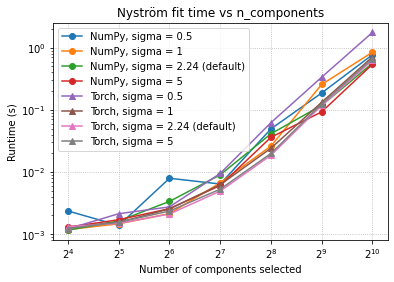

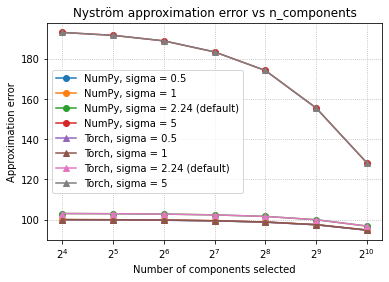

Random clustered data


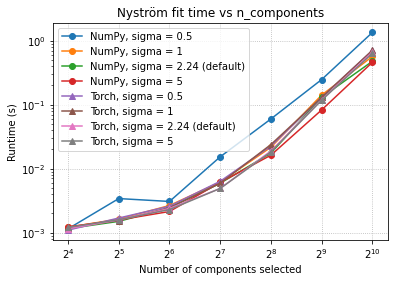

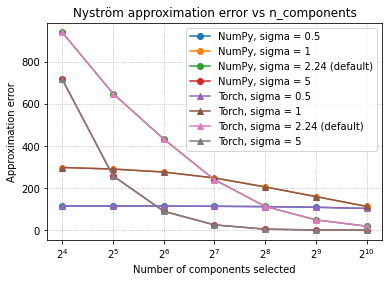

In [ ]:
# Make all the plots

print("Random data")
plt_1(r_time_np, r_time_torch, r_err_np, r_err_torch, random_data)

print("Random clustered data")
plt_1(c_time_np, c_time_torch, c_err_np, c_err_torch, data_clustered)

# print("GloVe")
# plt_1(gl_time_np, gl_time_torch, gl_err_np, gl_err_torch, GLOVE)

# print("MNIST")
# plt_1(mn_time_np, mn_time_torch2, mn_err_np, mn_err_torch, MNIST_np)

### Plots 2: Features

In [ ]:
random_sets = []
clustered_sets = []

In [ ]:
for i in range(3,20):
    data_clustered_f, _ = make_blobs(n_samples=1000, n_features=i, centers=5)
    data_clustered_ft = torch.tensor(data_clustered_f, dtype=torch.float64)
    clustered_sets.append((data_clustered_f, data_clustered_ft))
    
    random_data = np.random.uniform(0,20,size = (1000,i))
    random_data_t = torch.tensor(random_data, dtype=torch.float64)
    random_sets.append((random_data, random_data_t))

In [ ]:
def plot_2(data_lst):
    time_np = []
    time_torch = []
    err_np = []
    err_torch = []
    for d in data_lst:
        k_full = rbf_kernel(d[0])

        # torch
        torch.cuda.synchronize()
        start = time.time()
        torch.cuda.synchronize() # see if this makes a difference
        nystrom_tk = Nystrom_TK(n_components=500, kernel='rbf', random_state=0).fit(d[1])
        end = time.time()
        fit_time = end-start
        time_torch.append(fit_time)

        x_ap_t = nystrom_tk.transform(d[1], dense=True)
        k_ap_rbf_t = x_ap_t @ x_ap_t.T
        err_rbf = np.linalg.norm(k_full - k_ap_rbf_t.cpu().numpy())
        err_torch.append(err_rbf)

        #numpy
        start = time.time()
        nystrom_nk = Nystrom_NK(n_components=500, kernel='rbf', random_state=0).fit(d[0])
        end = time.time()
        fit_time = end-start
        time_np.append(fit_time)

        x_ap_t = nystrom_nk.transform(d[0], dense=True)
        k_ap_rbf_t = x_ap_t @ x_ap_t.T
        err_rbf = np.linalg.norm(k_full - k_ap_rbf_t)
        err_np.append(err_rbf)

    return time_np, time_torch, err_np, err_torch

In [ ]:
c_time_np, c_time_torch, c_err_np, c_err_torch = plot_2(clustered_sets)

In [ ]:
r_time_np, r_time_torch, r_err_np, r_err_torch = plot_2(random_sets)

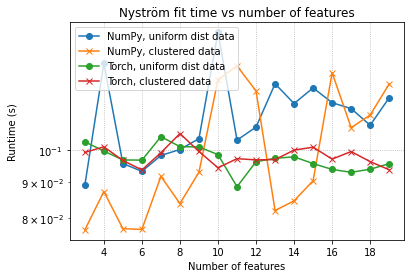

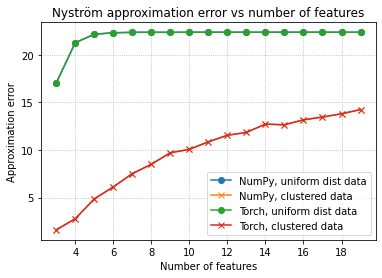

In [ ]:
x_ax = list(range(3,20))

plt.plot(x_ax, r_time_np, marker ="o", label = 'NumPy, uniform dist data')
plt.plot(x_ax, c_time_np, marker ="x", label = 'NumPy, clustered data')
plt.plot(x_ax, r_time_torch, marker ="o", label = 'Torch, uniform dist data')
plt.plot(x_ax, c_time_torch, marker ="x", label = 'Torch, clustered data')
plt.xlabel("Number of features")
plt.ylabel("Runtime (s)")
plt.yscale("log")
plt.title("Nyström fit time vs number of features")
plt.grid(True, which="major", linestyle="dotted")
plt.legend()
plt.show()

plt.plot(x_ax, r_err_np, marker ="o", label = 'NumPy, uniform dist data')
plt.plot(x_ax, c_err_np, marker ="x", label = 'NumPy, clustered data')
plt.plot(x_ax, r_err_torch, marker ="o", label = 'Torch, uniform dist data')
plt.plot(x_ax, c_err_torch, marker ="x", label = 'Torch, clustered data')
plt.title("Nyström approximation error vs number of features")
plt.xlabel("Number of features")
plt.ylabel("Approximation error")
plt.grid(True, which="major", linestyle="dotted")
plt.legend()
plt.show()

### Plots 3: K\_approx operations

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#print(device)

In [ ]:
def pairwise_kernels(kernel, x, y=None, sigma=None, lang = 'torch'):
    # lang: 'torch' or 'numpy'
    '''Helper function to build kernel
    Args:   x[np.array or torch.tensor] = data
            y[np.array or torch.tensor] = array/tensor
            dense[bool] = False to work with lazy tensor reduction,
                          True to work with dense arrays/tensors
        
    Returns:
            K_ij[LazyTensor] if dense = False
            K_ij[np.array or torch.tensor] if dense = True
    '''
    if sigma is None:
      sigma = np.sqrt(x.shape[1])

    if y is None:
        y = x
    
    if lang == 'torch':
        x = (x / sigma).to(device)
        y = (y / sigma).to(device)

        x_i, x_j = LazyTensor(x[:, None, :]), LazyTensor(y[None, :, :])
        D_ij = ((x_i - x_j) ** 2).sum(dim=2)
        K_ij = (-D_ij).exp()
    
    else:
        x_i, x_j = LazyTensor_n(x[:, None, :]), LazyTensor_n(y[None, :, :])
        D_ij = ((x_i - x_j) ** 2).sum(dim=2)
        K_ij = (-D_ij).exp()

    return K_ij

In [ ]:
from pykeops.numpy import LazyTensor as LazyTensor_n
from pykeops.torch import LazyTensor

def plot_3(data, data_t):

    # generate a random vector for computation
    rnd_vector = torch.rand(10000, dtype=torch.float64)*100 # row vector
    rnd_vector_t = rnd_vector.to(device)
    rnd_vector_np = rnd_vector.numpy()

    # get brute force computation time for torch
    start = time.time()
    kernel_brute_torch = pairwise_kernels('rbf', data_t, lang='torch')
    end =  time.time()
    brute_overhead_t = end-start

    start = time.time()
    res = kernel_brute_torch @ rnd_vector_t
    end = time.time()
    brute_time_t = end-start

    # get brute force computation time for numpy
    start = time.time()
    kernel_brute_np = pairwise_kernels('rbf', data, lang='numpy')
    end =  time.time()
    brute_overhead_np = end-start

    start = time.time()
    res = kernel_brute_np @ rnd_vector_np
    end = time.time()
    brute_time_np = end-start

    # initialize storage
    mult_times_np = []
    mult_times_torch = []
    overhead_np = []
    overhead_torch = []

    for i in NS:
        start= time.time()
        n_tk = Nystrom_TK(n_components=i, kernel='rbf', random_state=0).fit(data_t)
        approx_b = n_tk.K_approx(data_t)
        end = time.time()
        overhead_torch.append(end-start)

        start = time.time()
        res = approx_b @ rnd_vector_t
        end = time.time()
        mult_time = end-start
        mult_times_torch.append(mult_time)
    
    for i in NS:
        start= time.time()
        n_tk = Nystrom_NK(n_components=i, kernel='rbf', random_state=0).fit(data)
        approx_b = n_tk.K_approx(data)
        end = time.time()
        overhead_np.append(end-start)

        start = time.time()
        res = approx_b @ rnd_vector_np
        end = time.time()
        mult_time = end-start
        mult_times_np.append(mult_time)

    speed_inc_np = [brute_time_np/item for item in mult_times_np]
    speed_inc_t = [brute_time_t/item for item in mult_times_torch]

    return mult_times_np, mult_times_torch, speed_inc_np, speed_inc_t, overhead_np, overhead_torch, brute_time_np, brute_time_t, brute_overhead_np, brute_overhead_t


In [ ]:
times_np, times_torch, speed_np, speed_t, oh_np, oh_t, b_time_np, b_time_t, b_oh_np, b_oh_t = plot_3(data_clustered, data_clustered_t)

In [ ]:
r_times_np, r_times_torch, r_speed_np, r_speed_t, r_oh_np, r_oh_t, r_b_time_np, r_b_time_t, r_b_oh_np, r_b_oh_t = plot_3(data_clustered, data_clustered_t)

In [ ]:
print(b_time_np)
print(b_time_t)

0.0761423110961914
0.10356473922729492


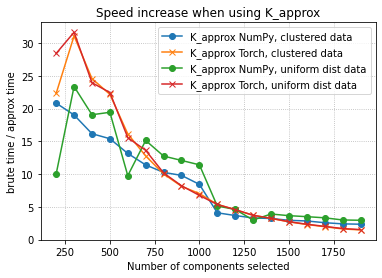

In [ ]:
# plot time difference


plt.plot(NS, speed_np, marker = "o", label='K_approx NumPy, clustered data')
plt.plot(NS, speed_t, marker ="x", label = 'K_approx Torch, clustered data')

plt.plot(NS, r_speed_np, marker = "o", label='K_approx NumPy, uniform dist data')
plt.plot(NS, r_speed_t, marker ="x", label = 'K_approx Torch, uniform dist data')

plt.title("Speed increase when using K_approx")
plt.xlabel("Number of components selected")
plt.ylabel("brute time / approx time")
plt.xscale("log", xbase=2)
plt.grid(True, which="major", linestyle="dotted")
plt.legend()
plt.show()

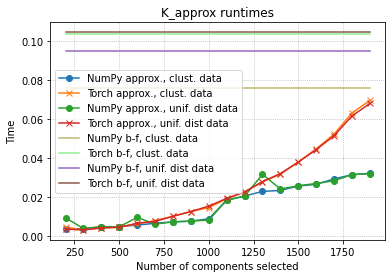

In [ ]:
plt.plot(NS, times_np, marker = "o", label='NumPy approx., clust. data')
plt.plot(NS, times_torch, marker ="x", label = 'Torch approx., clust. data')
plt.plot(NS, r_times_np, marker = "o", label='NumPy approx., unif. dist data')
plt.plot(NS, r_times_torch, marker ="x", label = 'Torch approx., unif. dist data')

plt.plot(NS, [b_time_np for item in times_np], color='darkkhaki', label='NumPy b-f, clust. data')
plt.plot(NS, [b_time_t for item in times_torch], color='lightgreen', label='Torch b-f, clust. data')
plt.plot(NS, [r_b_time_np for item in times_np], label='NumPy b-f, unif. dist data')
plt.plot(NS, [r_b_time_t for item in times_torch], label='Torch b-f, unif. dist data')

plt.title("K_approx runtimes")
plt.xlabel("Number of components selected")
plt.ylabel("Time (s)")
plt.yscale("log")
plt.xscale("log", xbase=2)
plt.grid(True, which="major", linestyle="dotted")
plt.legend()
plt.show()

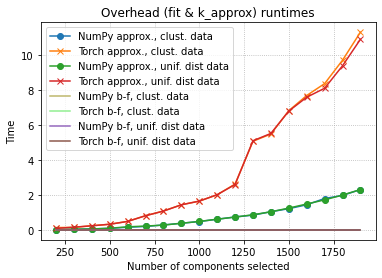

In [ ]:
plt.plot(NS, oh_np, marker = "o", label='NumPy approx., clust. data')
plt.plot(NS, oh_t, marker ="x", label = 'Torch approx., clust. data')
plt.plot(NS, r_oh_np, marker = "o", label='NumPy approx., unif. dist data')
plt.plot(NS, r_oh_t, marker ="x", label = 'Torch approx., unif. dist data')

plt.plot(NS, [b_oh_np for item in times_np], color='darkkhaki', label='NumPy b-f, clust. data')
plt.plot(NS, [b_oh_t for item in times_torch], color='lightgreen', label='Torch b-f, clust. data')
plt.plot(NS, [r_b_oh_np for item in times_np], label='NumPy b-f, unif. dist data')
plt.plot(NS, [r_b_oh_t for item in times_torch], label='Torch b-f, unif. dist data')

plt.title("Overhead (fit & k_approx) runtimes")
plt.xlabel("Number of components selected")
plt.ylabel("Time (s)")
plt.yscale("log")
plt.xscale("log", xbase=2)
plt.grid(True, which="major", linestyle="dotted")
plt.legend()
plt.show()

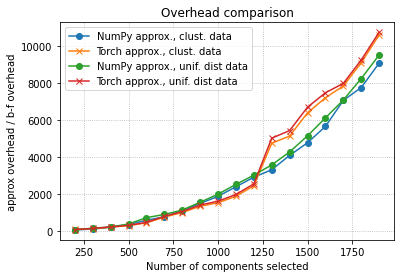

In [ ]:
plt.plot(NS, [item/b_oh_np for item in oh_np], marker = "o", label='NumPy approx., clust. data')
plt.plot(NS, [item/b_oh_t for item in oh_t], marker ="x", label = 'Torch approx., clust. data')
plt.plot(NS, [item/r_b_oh_np for item in r_oh_np], marker = "o", label='NumPy approx., unif. dist data')
plt.plot(NS, [item/r_b_oh_t for item in r_oh_t], marker ="x", label = 'Torch approx., unif. dist data')

# plt.plot(list(range(200,2000,100)), [b_oh_np for item in times_np], color='darkkhaki', label='NumPy b-f, clust. data')
# plt.plot(list(range(200,2000,100)), [b_oh_t for item in times_torch], color='lightgreen', label='Torch b-f, clust. data')
# plt.plot(list(range(200,2000,100)), [r_b_oh_np for item in times_np], label='NumPy b-f, unif. dist data')
# plt.plot(list(range(200,2000,100)), [r_b_oh_t for item in times_torch], label='Torch b-f, unif. dist data')

plt.title("Overhead comparison")
plt.xlabel("Number of components selected")
plt.xscale("log")
plt.ylabel("approx overhead / b-f overhead")
plt.grid(True, which="major", linestyle="dotted")
plt.legend()
plt.show()

### Plots 4: KeOps Nystrom vs Sklearn

In [ ]:
def get_runtime(X, X_t, data_name, kernel_keops, kernel_sklearn):
    np_fit = []
    torch_fit = []
    sklearn_fit = []
    np_tr = []
    torch_tr = []
    sklearn_tr = []

    for n_components in NS:

        print(f"Numpy, {n_components}")
        # Numpy: time fit
        start = time.time()
        nystrom = Nystrom_NK(kernel = kernel_keops, random_state = 0, n_components=n_components).fit(X)
        end = time.time()
        elapsed = end - start
        np_fit.append(elapsed)

        # Numpy: time transform
        start = time.time()
        x_new = nystrom.transform(X, dense=True)
        end = time.time()
        elapsed = end - start
        np_tr.append(elapsed)

        print(f"Torch, {n_components}")
        # Torch: time fit
        torch.cuda.synchronize()
        start = time.time()
        torch.cuda.synchronize()
        nystrom = Nystrom_TK(kernel = kernel_keops, random_state = 0, n_components=n_components).fit(X_t)
        end = time.time()
        elapsed = end - start
        torch_fit.append(elapsed)

        # Torch: time transform
        torch.cuda.synchronize()
        start = time.time()
        torch.cuda.synchronize()
        x_new = nystrom.transform(X_t, dense=False)
        end = time.time()
        elapsed = end - start
        torch_tr.append(elapsed)

        print(f"Sklearn, {n_components}")
        # Sklearn: time fit
        start = time.time()
        sk_n = Nystroem(kernel=kernel_sklearn, n_components=n_components, random_state=0).fit(X)
        end = time.time()
        elapsed = end - start
        sklearn_fit.append(elapsed)

        # Torch: time transform
        start = time.time()
        x_new = sk_n.transform(X)
        end = time.time()
        elapsed = end - start
        sklearn_tr.append(elapsed)

    return np_fit, torch_fit, sklearn_fit, np_tr, torch_tr, sklearn_tr

In [ ]:
def runtime_plt(fit_n, fit_t, fit_sk, tr_n, tr_t, tr_sk, name):
    plt.plot(NS, fit_n, marker ="o", label = 'Nyström NumPy (KeOps)')
    plt.plot(NS, fit_sk, marker = "x", label = 'Nyström Sklearn')
    plt.plot(NS, fit_t, marker = "*", label = 'Nyström Torch (KeOps)')
    plt.legend()
    plt.xlabel("Number of components")
    plt.xscale("log", xbase=2)
    plt.ylabel("Time (s)")
    plt.yscale("log")
    plt.title(f"Fit runtime on {name}") # uniformly distributed random data
    plt.grid(True, which="major", linestyle="dotted")
    plt.show()

    plt.plot(NS, tr_n, marker ="o", label = 'Nyström NumPy (KeOps)')
    plt.plot(NS, tr_sk, marker = "x", label = 'Nyström Sklearn')
    plt.plot(NS, tr_t, marker = "*", label = 'Nyström Torch (KeOps)')
    plt.legend()
    plt.xlabel("Number of components")
    plt.xscale("log", xbase=2)
    plt.ylabel("Time (s)")
    plt.title(f"Transform runtime on {name}")
    plt.grid(True, which="major", linestyle="dotted")
    plt.show()

In [ ]:
r_np_fit, r_torch_fit, r_sklearn_fit, r_np_tr, r_torch_tr, r_sklearn_tr = get_runtime(random_data, random_data_t, 'Random unclustered data', 'rbf', 'rbf')
c_np_fit, c_torch_fit, c_sklearn_fit, c_np_tr, c_torch_tr, c_sklearn_tr = get_runtime(data_clustered, data_clustered_t, 'Random clustered data', 'rbf', 'rbf')
gl_np_fit, gl_torch_fit, gl_sklearn_fit, gl_np_tr, gl_torch_tr, gl_sklearn_tr = get_runtime(GLOVE, GLOVE_t, 'GLOVE (10k samples)', 'rbf', 'rbf')

# MNIST runtimes & plots are below

Numpy, 16
Torch, 16
[pyKeOps] Initializing build folder for dtype=float64 and lang=torch in /root/.cache/pykeops-1.5-cpython-37 ... done.
[pyKeOps] Compiling libKeOpstorchf637052721 in /root/.cache/pykeops-1.5-cpython-37:
       formula: Sum_Reduction((Exp(Minus(Sum(Square((Var(0,19,0) - Var(1,19,1)))))) * Var(2,16,1)),0)
       aliases: Var(0,19,0); Var(1,19,1); Var(2,16,1); 
       dtype  : float64
... 
[pyKeOps] Compiling pybind11 template libKeOps_template_660bc304e8 in /root/.cache/pykeops-1.5-cpython-37 ... done.
Done.
Sklearn, 16
Numpy, 32
Torch, 32
[pyKeOps] Compiling libKeOpstorch64939b8eea in /root/.cache/pykeops-1.5-cpython-37:
       formula: Sum_Reduction((Exp(Minus(Sum(Square((Var(0,19,0) - Var(1,19,1)))))) * Var(2,32,1)),0)
       aliases: Var(0,19,0); Var(1,19,1); Var(2,32,1); 
       dtype  : float64
... 
Done.
Sklearn, 32
Numpy, 64
Torch, 64
[pyKeOps] Compiling libKeOpstorch03d881da3a in /root/.cache/pykeops-1.5-cpython-37:
       formula: Sum_Reduction((Exp(Minus(Sum

AssertionError: ignored

In [ ]:
# Plot the first 3 data sets

runtime_plt(r_np_fit, r_torch_fit, r_sklearn_fit, r_np_tr, r_torch_tr, r_sklearn_tr, "uniformly distributed random data" )
runtime_plt(c_np_fit, c_torch_fit, c_sklearn_fit, c_np_tr, c_torch_tr, c_sklearn_tr, "clustered random data" )
runtime_plt(gl_np_fit, gl_torch_fit, gl_sklearn_fit, gl_np_tr, gl_torch_tr, gl_sklearn_tr, "GloVe25" )

In [ ]:
train_loader = DataLoader(MNIST('/files/', train=True, download=True,
                                transform=Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])),
                          batch_size=5000, shuffle=True)

In [ ]:
# data set 3: MNIST

examples = enumerate(train_loader)
_, (example_data, _) = next(examples)

# create two versions of the data set, on
MNIST_t = example_data.permute(1,0,2,3)
MNIST_t = MNIST_t.view(5000,784)
MNIST_np = MNIST_t.numpy()

In [ ]:
# Memory overflow issues! do only 5k or something

NS = [
    100,
    200,
    500,
    1000]

mn_np_fit, mn_torch_fit, mn_sklearn_fit, mn_np_tr, mn_torch_tr, mn_sklearn_tr = get_runtime(MNIST_np, MNIST_t, 'MNIST (10k samples)', 'rbf', 'rbf')

# Transform for MNIST:  

# NumPy crashes at 1k components  for 5k samples, can do 500
# NumPy crashes at 500 components for 10k samples, can do 200

# Sklearn can do up to 1k for 5k samples
# Sklearn can do up to 1k for 10k samples

# TORCH
# dense=True: crashes at 500 components for 5k samples, can do 200
# dense=False: crashes at 200 components for 5k samples, lol.

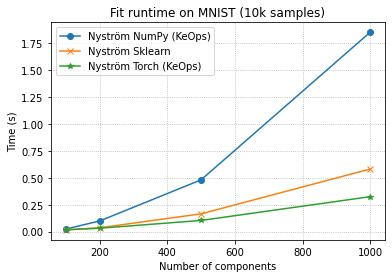

In [ ]:
# MNIST

plt.plot(NS, mn_np_fit, marker ="o", label = 'Nyström NumPy (KeOps)')
plt.plot(NS, mn_sklearn_fit, marker = "x", label = 'Nyström Sklearn')
plt.plot(NS, mn_torch_fit, marker = "*", label = 'Nyström Torch (KeOps)')
plt.legend()
plt.xlabel("Number of components")
plt.ylabel("Time (s)")
plt.title(f"Fit runtime on MNIST (10k samples)")
plt.grid(True, which="major", linestyle="dotted")
plt.show()

# plt.plot(NS, mn_np_tr, marker ="o", label = 'Nyström NumPy (KeOps)')
# plt.plot(NS, mn_sklearn_tr, marker = "x", label = 'Nyström Sklearn')
# plt.plot(NS, mn_torch_tr, marker = "*", label = 'Nyström Torch (KeOps)')
# plt.legend()
# plt.xlabel("Number of components")
# plt.ylabel("Time (s)")
# plt.title(f"Transform runtime on GLOVE (10k samples)")
# plt.grid(True, which="major", linestyle="dotted")
# plt.show()

### Other

**Summary (Runtimes):** \\
* Looks like our code is doing quite a bit better (when compared to Sklearn) for data sets with small number of features

* Also looks like Sklearn is doing much better when using the gaussian kernel compared to a custom one (though the exp kernel perfomance should be further tested)

**Summary (avg distance):** \\
Differences resulting from random seed selection are minor. \\
As of now, this is not saying as much because it depends on the data scale etc, but if we implement more sophisticated sampling, it will be useful to compare the mean distance given the same data but different sampling.

Right now Sklearn hasthe same distances, but we could improve by better sampling, but this is very likely to be computationally too expensive to be worth it.

In [ ]:
from pykeops.numpy import LazyTensor as LazyTensor_n

N = 10000
X = np.random.randn(N,11).astype("float32")
b = np.random.randn(N,1).astype("float32")

print("n_components = 3000", "\n")
nyst = Nystrom_NK(n_components=3000, random_state=0).fit(X)

K_n = nyst.K_approx(X)
K = pairwise_kernels('rbf', X, lang='numpy')

start= time.time()
r1 = K @ b
end = time.time()
print(f"bruteforce time is {end-start}")

start= time.time()
r2 = K_n @ b
end = time.time()
print(f"K_approx time is {end-start} \n")


print("n_components = 100")
nyst = Nystrom_NK(n_components=100, random_state=0).fit(X)

K_n = nyst.K_approx(X)
K = pairwise_kernels('rbf', X, lang='numpy')

start= time.time()
r1 = K @ b
end = time.time()
print(f"bruteforce time is {end-start}")

start= time.time()
r2 = K_n @ b
end = time.time()
print(f"K_approx time is {end-start}")

n_components = 3000 

bruteforce time is 0.00789332389831543
K_approx time is 0.012302875518798828 

n_components = 100
bruteforce time is 0.0074710845947265625
K_approx time is 0.004326581954956055
